# Food Vision: 101 Food Classes


### Check GPU

In order to use mixed precision training, we need access to a Tesla T4 (from within Google Colab - Thanks Google!) or a GPU with a compute capability score of 7.0 or higher.

In [ ]:
!nvidia-smi -L
!pip install tensorflow==2.4.1
import tensorflow as tf
print(tf.__version__)

GPU 0: Tesla T4 (UUID: GPU-e8b2f147-c06f-2924-e5f6-94dd50aa8546)
     |████████████████████████████████| 394.3MB 42kB/s 
     |████████████████████████████████| 471kB 50.5MB/s 
     |████████████████████████████████| 3.8MB 26.6MB/s 
     |████████████████████████████████| 2.9MB 40.4MB/s 
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0
2.4.1


### Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-12 22:06:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-12 22:06:11 (99.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to download Food101 dataset

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
# Load in the data (takes 5-6 minutes)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"], # validation is the same as test in this case
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteMN7URL/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteMN7URL/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Becoming one with the data

To become one with the data, we want to find:
* class names
* shape of input data (image tensors)
* The datatype of the input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [ ]:
# Features of data
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# Output info about the training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 25
  Class name (str form): club_sandwich
  


In [ ]:
# What does the image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[135, 156, 175],
        [125, 148, 166],
        [114, 136, 159],
        ...,
        [ 26,   5,  12],
        [ 26,   3,  11],
        [ 27,   4,  12]],

       [[128, 150, 171],
        [115, 140, 160],
        [102, 127, 149],
        ...,
        [ 28,   7,  14],
        [ 29,   6,  14],
        [ 30,   7,  15]],

       [[112, 139, 160],
        [ 99, 127, 148],
        [ 87, 115, 137],
        ...,
        [ 29,   6,  16],
        [ 31,   5,  16],
        [ 32,   6,  17]],

       ...,

       [[ 48,  47,  53],
        [ 53,  52,  58],
        [ 52,  51,  59],
        ...,
        [111,  99,  99],
        [108,  98,  97],
        [106,  96,  97]],

       [[ 44,  45,  47],
        [ 48,  49,  51],
        [ 46,  47,  51],
        ...,
        [108,  96,  98],
        [105,  94,  98],
        [102,  93,  96]],

       [[ 40,  42,  41],
        [ 45,  47,  46],
        [ 44,  45,  49],
        ...,
        [105,  95,  9

In [ ]:
# What are the min and max values our the image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

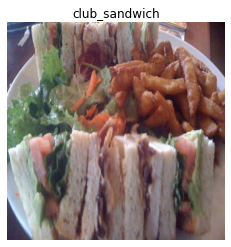

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain format - e.g. batched, normalized, etc.

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to the data.

What we know about the data:
* It's in `uint8` format
* Comprised of all different sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an `EfficientNetBx` pretrained model from `tf.keras.applications` we don't need to rescale the data because these architectures have rescaling built-in. 

Function goals:
1. Reshape the images to be the same size
2. Convert the dtype of the image tensors from `uint8` to `float32`

In [ ]:
# Preprocessing image function
def preprocess_image(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' (or any other) -> 'float32' and reshapes
  image to [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  return tf.cast(image, tf.float32), label # return (image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_image = preprocess_image(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_image[:2]}..., \nShape: {preprocessed_image.shape}, \nDatatype: {preprocessed_image.dtype}")

Image before preprocessing:
 [[[135 156 175]
  [125 148 166]
  [114 136 159]
  ...
  [ 26   5  12]
  [ 26   3  11]
  [ 27   4  12]]

 [[128 150 171]
  [115 140 160]
  [102 127 149]
  ...
  [ 28   7  14]
  [ 29   6  14]
  [ 30   7  15]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[122.83163   146.17346   165.81633  ]
  [ 95.07653   122.122444  144.47958  ]
  [ 72.5051    106.994896  134.34694  ]
  ...
  [ 20.714308    2.3570995   3.9285717]
  [ 27.285715    6.285714   13.285714 ]
  [ 28.28575     5.2857494  13.285749 ]]

 [[ 88.65305   119.41326   140.41327  ]
  [ 74.59694   108.30102   133.02042  ]
  [ 75.2551    112.57143   141.91325  ]
  ...
  [ 26.857143    6.285671   11.040798 ]
  [ 30.061235    6.86222    16.795908 ]
  [ 31.688843    5.688843   16.688843 ]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

This pipeline is going to be lightning fast.

In [ ]:
train_data

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# Map preprocessing function to training data (and parallelize)
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle (again just to be safe) train_data and turn it into batches and prefetch it (load it faster)
# buffer_size -> how many elements to shuffle at a single time - could do the length of the train data but it takes a ton of memory
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) 

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

> "Hey TensorFlow, map this preprocessing function (`preprocess_image`) across the training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch"

## Create modelling callbacks

Since this dataset is pretty big, it's important to have some callbacks set up so we can track our progress as these experiments will take some time.

* TensorBoard callback to log training results (so we can visualize them later)
* ModelCheckpoint callback to save our model's performance after feature extraction

In [ ]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      verbose=0) # no output pls

## Setting up mixed precision training

Mixed precision utilizes a combination of float32 and float16 datatypes to speed up model performance

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to float16

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
!nvidia-smi

Sat Jun 12 22:16:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W /  70W |    254MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze patterns

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBx models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1/255.)(x)
x = base_model(inputs, training=False) # make sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model - since the labels are ints and not one-hot encoded, sparse categorical crossentropy should be used
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Checking layer dtype policies - Are we using mixed precision?
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? If `False`, weights are frozen
* `layer.dtype`: the datatype a layer **stores** its variables in
* `layer.dtype_policy`: the datatype policy a layer **computes** on its variables with

In [ ]:
# Check layer dtype policies for the layers in the base model
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [ ]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extraction = model.fit(train_data,
                                                        epochs=3,
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)),
                                                        callbacks=[create_tensorboard_callback("logs", "eff_netb0_101_classes_feature_extract_mixed_precision"), model_checkpoint])

Saving TensorBoard log files to: logs/eff_netb0_101_classes_feature_extract_mixed_precision/20210612-221608
Epoch 1/3
2368/2368 [==============================] - 230s 81ms/step - loss: 2.3221 - accuracy: 0.4685 - val_loss: 1.2287 - val_accuracy: 0.6706


Epoch 2/3
2368/2368 [==============================] - 166s 69ms/step - loss: 1.3235 - accuracy: 0.6610 - val_loss: 1.1376 - val_accuracy: 0.6947


Epoch 3/3
2368/2368 [==============================] - 171s 72ms/step - loss: 1.1478 - accuracy: 0.7016 - val_loss: 1.0913 - val_accuracy: 0.7039


In [ ]:
# Evaluate mdoel on whole dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 57s 72ms/step - loss: 1.0841 - accuracy: 0.7083


[1.08411705493927, 0.7082772254943848]

In [ ]:
# Save model
model.save("feature_extraction_101_food_classes_EfficientNetB0")

INFO:tensorflow:Assets written to: feature_extraction_101_food_classes_EfficientNetB0/assets


INFO:tensorflow:Assets written to: feature_extraction_101_food_classes_EfficientNetB0/assets


In [ ]:
# Load model and check score
loaded_model = tf.keras.models.load_model("feature_extraction_101_food_classes_EfficientNetB0")
loaded_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 50s 62ms/step - loss: 1.0841 - accuracy: 0.7083


In [ ]:
# Compare scores from test set evaluation pre and post save/load - this is showing as false because of the way computers store numbers
results_feature_extract_model == loaded_model_results

False

In [ ]:
results_feature_extract_model

[1.08411705493927, 0.7082772254943848]

In [ ]:
loaded_model_results

[1.0841180086135864, 0.7082772254943848]

In [ ]:
# As you can see, the accuracy score is the same at index 1, but the loss score is slightly different. To determine if this is a fluke, we can check their proximity with np.isclose

import numpy as np

In [ ]:
np.isclose(results_feature_extract_model, loaded_model_results)

array([ True,  True])

## Fine-tune feature extraction model 
Goal: to beat the `DeepFood paper` - https://arxiv.org/ftp/arxiv/papers/1606/1606.05675.pdf

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

--2021-06-12 22:28:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.240, 172.217.8.16, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  --.-KB/s    in 0.09s   

2021-06-12 22:28:09 (180 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# Unzip the saved model
!mkdir downloaded_model_ztm
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_model_ztm

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_model_ztm/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_model_ztm/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_model_ztm/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_model_ztm/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_model_ztm/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_model_ztm/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
# Load and evaluate
downloaded_model = tf.keras.models.load_model("downloaded_model_ztm/07_efficientnetb0_feature_extract_model_mixed_precision")
downloaded_model_results = downloaded_model.evaluate(test_data)
downloaded_model_results

790/790 [==============================] - 51s 62ms/step - loss: 1.0881 - accuracy: 0.7066


[1.0881214141845703, 0.7065742611885071]

In [ ]:
# Summary
downloaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
# Setting all trainable layers to False
for layer in downloaded_model.layers[1].layers:
  layer.trainable = False

In [ ]:
# Setting all trainable layers to True to unfreeze them
for layer in downloaded_model.layers[1].layers:
  layer.trainable = True
  print(layer.name, layer.trainable)

input_1 True
rescaling True
normalization True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn True
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn True
block2b_expand_activation True
block2b_dwconv True
block2b_bn True
block2b_activation True
block2b_se_squeeze True
block2b_se_reshape True
block2b_se_reduce True
block2b_se_expand True
block2b_se_excite True
block2b_project_conv True
block2b_project_bn True
block2b_drop True
bloc

In [ ]:
# Checking dtypes and policies
for layer in downloaded_model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

## Setup EarlyStopping callback
We want to halt training if the model's validation loss does not improve for 3 epochs:
* Monitor `val_loss`
* Stop training after 3 epochs


In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

## Setup ModelCheckpoint callback
Save the best model **only** during fine-tuning
* Monitor `val_loss`

In [ ]:
# Set up path for model checkpoint
checkpoint_path = 'model_checkpoints/cp.ckpt'

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                               monitor='val_loss',
                                                               save_best_only=True,
                                                               verbose=0)

## Setup Learning Rate Reduction callback

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

## Compile the model

Prepare model for fine-tuning

In [ ]:
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [ ]:
history_loaded_model_fine_tuned = loaded_model.fit(train_data,
                                                   epochs=100,
                                                   steps_per_epoch=len(train_data),
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15 * len(test_data)),
                                                   callbacks=[create_tensorboard_callback("logs", "fine_tune_efficientnetB0_101_classes"),
                                                              early_stopping_callback,
                                                              model_checkpoint_callback,
                                                              reduce_lr])

Saving TensorBoard log files to: logs/fine_tune_efficientnetB0_101_classes/20210612-222915
Epoch 1/100
2368/2368 [==============================] - 310s 125ms/step - loss: 0.9905 - accuracy: 0.7342 - val_loss: 0.8302 - val_accuracy: 0.7741
INFO:tensorflow:Assets written to: model_checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/cp.ckpt/assets


Epoch 2/100
2368/2368 [==============================] - 293s 123ms/step - loss: 0.5955 - accuracy: 0.8379 - val_loss: 0.7908 - val_accuracy: 0.7873
INFO:tensorflow:Assets written to: model_checkpoints/cp.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/cp.ckpt/assets


Epoch 3/100
2368/2368 [==============================] - 292s 122ms/step - loss: 0.3357 - accuracy: 0.9052 - val_loss: 0.8529 - val_accuracy: 0.7836
Epoch 4/100
2368/2368 [==============================] - 291s 122ms/step - loss: 0.1662 - accuracy: 0.9524 - val_loss: 0.9512 - val_accuracy: 0.7786

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 5/100
2368/2368 [==============================] - 292s 123ms/step - loss: 0.0518 - accuracy: 0.9872 - val_loss: 1.0291 - val_accuracy: 0.8043


In [ ]:
results_fine_tuned_model = loaded_model.evaluate(test_data)
results_fine_tuned_model

790/790 [==============================] - 48s 61ms/step - loss: 1.0395 - accuracy: 0.7992


[1.039463996887207, 0.7992475032806396]

## Export model for TensorFlow JS

In [ ]:
pip install tensorflowjs

     |████████████████████████████████| 71kB 9.9MB/s 


In [ ]:
import tensorflowjs as tfjs

In [ ]:
tfjs.converters.save_keras_model(loaded_model, "myModel")

weight normalization/count with shape () and dtype int64 was auto converted to the type int32
